In [ ]:
import sys
import numpy as np

from PySDM.backends import CPU, GPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics import Breakup
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesConcentration, ParticleMeanRadius
from PySDM.products.stats.timers import WallTime

from matplotlib import pyplot

## AlwaysN fragments, Golovin kernel

In [ ]:
from PySDM.initialisation.spectra import Exponential
from PySDM.physics.coalescence_kernels import ConstantK, Golovin
from PySDM.physics.breakup_fragmentations import AlwaysN
from PySDM.physics.coalescence_efficiencies import ConstEc, Berry1967
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
#from pystrict import strict

#@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**10
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 100, 200]
        self.kernel = Golovin(b=1500 / si.second)
        self.coal_eff = ConstEc(0.0)
        self.fragmentation = AlwaysN(n=3)
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

In [ ]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
#coalescence = Coalescence(settings.kernel, settings.coal_eff adaptive=settings.adaptive)
#builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    print(step, flush=True)
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get())
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend()

### <i> GPU testing

In [ ]:
from PySDM.initialisation.spectra import Exponential
from PySDM.physics.coalescence_kernels import ConstantK, Golovin
from PySDM.physics.breakup_fragmentations import AlwaysN
from PySDM.physics.coalescence_efficiencies import ConstEc, Berry1967
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
#from pystrict import strict

#@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 4
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 1, 2]
        self.kernel = Golovin(b=1500 / si.second)
        self.coal_eff = ConstEc(0.0)
        self.fragmentation = AlwaysN(n=3)
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

In [ ]:
settings = Settings()
backend = GPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
#coalescence = Coalescence(settings.kernel, settings.coal_eff adaptive=settings.adaptive)
#builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    print(step, flush=True)
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get())
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend()

* Sometimes hangs on illegal print statements in Numba
* current source of error: self.kernel is computed wrong

## SLAMS fragmentation kernel

In [ ]:
from PySDM.initialisation.spectra import Exponential
from PySDM.physics.coalescence_kernels import Golovin
from PySDM.physics.breakup_fragmentations import SLAMS
from PySDM.physics.coalescence_efficiencies import ConstEc, Berry1967
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
from pystrict import strict
from PySDM.products.dynamics.breakup import BreakupFragments

@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**10
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 1, 2]
        self.kernel = Golovin(b=1.5e3 / si.second)
        self.breakup_kernel = Golovin(b = 1e8 / si.second)
        self.fragmentation = SLAMS()
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

In [ ]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.breakup_kernel, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
coalescence = Coalescence(settings.breakup_kernel, adaptive=settings.adaptive)
builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range), BreakupFragments()]
core = builder.build(attributes, products)

for step in settings.output_steps:
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get())
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")

## Coalescence Efficiencies

In [ ]:
from PySDM.initialisation.spectra import Exponential
from PySDM.physics.coalescence_kernels import Golovin, Hydrodynamic
from PySDM.physics.breakup_fragmentations import SLAMS, AlwaysN
from PySDM.physics.coalescence_efficiencies import ConstEc, Berry1967
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
from pystrict import strict
from PySDM.products.dynamics.breakup import BreakupFragments

@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**10
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 1, 2]
        self.kernel = Golovin(b=1e5 / si.second)
        #self.kernel = Hydrodynamic()
        self.coal_eff = ConstEc(0.9)
        #self.coal_eff = Berry1967()
        #self.breakup_kernel = Golovin(b = 1.5e4 / si.second)
        #self.fragmentation = SLAMS()
        self.fragmentation = AlwaysN(n=5)
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

In [ ]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
#coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
#builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get())
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")

## GPU test

In [1]:
import sys
import numpy as np

from PySDM.backends import CPU, GPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics import Breakup
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesConcentration, ParticleMeanRadius
from PySDM.products.stats.timers import WallTime

from matplotlib import pyplot

In [8]:
from PySDM.initialisation.spectra import Exponential
from PySDM.physics.coalescence_kernels import ConstantK, Golovin
from PySDM.physics.breakup_fragmentations import AlwaysN
from PySDM.physics.coalescence_efficiencies import ConstEc, Berry1967
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
#from pystrict import strict

#@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**8
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 123
        self._steps = [0, 1, 2]
        self.kernel = Golovin(b=1500e3 / si.second)
        self.coal_eff = ConstEc(0.5)
        self.fragmentation = AlwaysN(n=3)
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

0
[27.26101585] [99.997952]
1
[25.3568027] [149.996928]
2
[22.67280108] [224.995363]


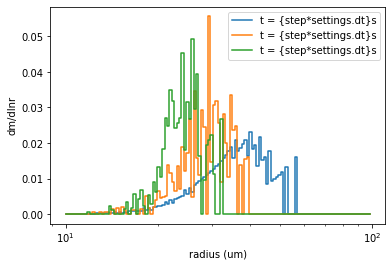

In [9]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
#coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
#builder.add_dynamic(coalescence)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    print(step, flush=True)
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get())
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend()

0
[27.26100772] [99.997952]
1
compute_gamma  [37.44157593 97.60696245 17.14551751 17.63749785 37.11452552 45.00077612
 24.38942484 14.3058792  26.19370266 64.69563209 76.09206482 39.2628167
  9.87849886 16.53023929 15.25732789 54.00168641 57.59758782 40.76567458
 16.71982293 18.35240987  0.58072511 35.64084826 14.71347029 22.39722112
 16.79778337 31.4290835  28.46926339  9.75586723 34.43312567  6.01672191
 27.6529782  24.68955593 10.02383229 89.48101876 20.6175271  75.92933816
 11.18149586 39.22777722 29.78914803 10.85233179 30.38202671 17.52006356
  3.62854107 23.62460831 12.6783427   6.59961189 18.90101285  2.76012049
 32.81559505 52.00931992 91.62284618 32.28082334 12.93538439 68.11865293
  0.74533632 12.07982565  9.26838562 54.29670238 42.08947189 39.33237947
 71.0797614  23.40668303 15.61720235 48.1967441  25.75655612 14.24534918
 24.51077762 29.79891068  3.17938559 30.62950827 16.90782875 26.95676866
 57.46605248 12.37147646 17.62111163 27.60391029 12.25339488 12.34703053
 19.605

/Users/emilydejong/Documents/PySDM/PySDM/backends/thrustRTC/thrustRTC.py:37: UserWarning: CUDA is not available, using FakeThrustRTC!
  warnings.warn('CUDA is not available, using FakeThrustRTC!')


[25.12644547] [149.606311]
2
compute_gamma  [26.26751526 21.07964311 10.15722726 45.2261327  28.73450855 69.78958141
 20.33470608 39.90231808 26.02714086 20.17223283  4.59805767 38.33642768
 27.77282838 47.53122904 33.19227438 29.26211754 10.47924604 36.6664404
 23.1839149  14.32689123 10.07705875 23.68427524  6.82619251 25.5298524
 22.34600912 15.00447435  6.4638723  31.57813547 35.34153568 22.99167616
 24.39131706 18.59454429 31.23077155 18.55218574 31.64400876 37.7079693
 22.93119472 14.72310675 37.06394518 14.58062426 16.00590064 19.57496593
 23.58992517  5.0486747  16.13157042 11.04144375 26.4891215  34.96509012
 15.76943216 17.93551059 22.13489938 39.70679471  6.08296764 46.59879988
 36.66254914 21.5682702  28.99518082 13.69591819 29.46106861 25.57076006
 11.51535276 31.06559244 21.79436139 66.19431687 12.16486613 16.54926698
 11.82711997 28.32065437 29.54280141 22.41648107 52.37744609 22.56097257
 17.97476961 17.63013436 25.73024107 18.20250058 60.5463688  22.04325168
 18.707671

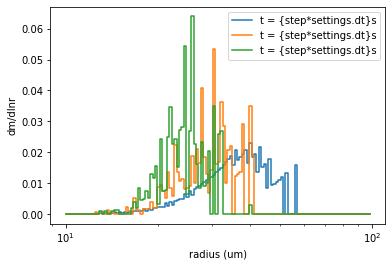

In [10]:
settings = Settings()
backend = GPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
#coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
#builder.add_dynamic(coalescence)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    print(step, flush=True)
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get())
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend()